# DATA SCIENCE WINTER TERM PROJECT

-----

## PROJECT: Using Data Science and Machine Learning to Explore Water Use Habit of Noah's Residents.

---------

**GROUP MEMBER:** 
- Trung Nguyen 
- Binh Nguyen


### I. Project Introduction

Sometimes, we feel like picking a time to shower can be a game of gacha. If we are lucky, the water pressure will be strong and you will have a good time showering. However, if we are unlucky, then we might have a rough time. 

Thanks to the collective dataset from the environmental dashboard, we can now look at how people in Noah use water.

This project aim is to look at the trend of the water usage in Noah and then try to predict it using Machine Learning. 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### II. Dataset Description

#### A. Dataset Overview
Our dataset is a collective dataset that is continuously taken for the last 5 years, from 2018 to 2021.

The format of the data looks something like this:

|Timestamp    |Water Use (gal)|
|:---         |:----:         |
|1/1/2018 0:00|0              |
|1/1/2018 0:15|0              |
|1/1/2018 0:30|0              |

As the meters take measures every 15 minutes, there will be a period of 15 minutes in between our timestamps.

#### B. Data Cleaning & Preprocessing

We deleted all rows that consist of all null values and incorrectly formatted data. Usually, this is enough. However, as there is a year of 2020 where people cannot be on campus so we decided to get rid of that whole period. We also looked into breaks and shutdowns but as we have those every year so our model will be able to recognize them.

After the cleaning process, we reformatted our data by splitting the our **Timestamp** into different columns: **Month, Day, Time, and Water**

Basically, our new table looks like this:

|     |Month|Day   |Time    |Water  |
|:----|:---:|:-----|:-------|:------|
|**0**|1    |Monday|08:00:00|0.00000|
|**1**|1    |Monday|08:15:00|0.00000|
|**2**|1    |Monday|08:30:00|0.00000|


In [3]:
df0 = pd.read_csv("Noah_5Years_000.csv", skiprows=4)
df1 = pd.read_csv("Noah_5Years_002.csv", skiprows=4)
df2 = pd.read_csv("Noah_5Years_003.csv", skiprows=4)

df = pd.concat([df0, df1, df2])
df = df[['Timestamp', 'Noah - Water Use (gal)']]
df[['Date', 'Time']] = df['Timestamp'].str.split(' ', expand = True)
df['Date'] = pd.to_datetime(df['Date'])
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day_name()
df = df[['Date', 'Year', 'Month', 'Day', 'Time', 'Noah - Water Use (gal)']]
df.columns = ['Date', 'Year', 'Month', 'Day', 'Time', 'Water']

df.dropna(inplace=True)
new_df = df


,Month,Day,Time,Water
0,1,Monday,08:00:00,0.00000
1,1,Monday,08:15:00,0.00000
2,1,Monday,08:30:00,0.00000
3,1,Monday,08:45:00,0.00000
4,1,Monday,09:00:00,0.00000
...,...,...,...,...
58063,12,Friday,22:45:00,2.28294
58064,12,Friday,23:00:00,4.01284
58065,12,Friday,23:15:00,7.57591
58066,12,Friday,23:30:00,0.27672


### III. Exploring the Trend

#### A. Over the Last 5 Years

Our first step is to look at the water usage in the last 5 consecutive years. By plotting out the bar chart, we can easily compare each year's usage.

This is our Dataset.

In [4]:
# new_df = pd.concat([df0, df1, df2])
# new_df = new_df[['Timestamp', 'Noah - Water Use (gal)']]
# new_df[['Date', 'Time']] = new_df['Timestamp'].str.split(' ', expand = True)
# new_df['Date'] = pd.to_datetime(new_df['Date'])
# new_df['Year'] = new_df['Date'].dt.year
# new_df['Month'] = new_df['Date'].dt.month
# new_df['Day'] = new_df['Date'].dt.day_name()
# new_df = new_df[['Date', 'Year', 'Month', 'Day', 'Time', 'Noah - Water Use (gal)']]

# new_df.dropna(inplace=True)
new_df

,Date,Year,Month,Day,Time,Water
0,2018-01-01,2018,1,Monday,00:00:00,0.00000
1,2018-01-01,2018,1,Monday,00:15:00,0.00000
2,2018-01-01,2018,1,Monday,00:30:00,0.00000
3,2018-01-01,2018,1,Monday,00:45:00,0.00000
4,2018-01-01,2018,1,Monday,01:00:00,0.00000
...,...,...,...,...,...,...
26092,2023-01-11,2023,1,Wednesday,14:30:00,10.03200
26093,2023-01-11,2023,1,Wednesday,14:45:00,12.62555
26094,2023-01-11,2023,1,Wednesday,15:00:00,4.08202
26095,2023-01-11,2023,1,Wednesday,15:15:00,5.05054


In [6]:
df2022 = new_df[new_df['Year'] == 2022]
df2022['Water'].sum(axis = 0)

505818.60224

Calculate the total usage of each year.

In [8]:
years = [2018, 2019, 2020, 2021, 2022]
water_use = []

for year in years:
    buffer = new_df[new_df['Year'] == year]
    total = buffer['Water'].sum(axis = 0)
    water_use.append(total)
    
# water_use
year_record = {
    'Year' : years,
    'Water Use (gal)' : water_use
}

year_df = pd.DataFrame(year_record, columns = ['Year', 'Water Use (gal)'])
year_df

,Year,Water Use (gal)
0,2018,396367.67509
1,2019,192178.86690
2,2020,33499.22911
3,2021,389750.09580
4,2022,505818.60224


Now we can plot it using bar chart.

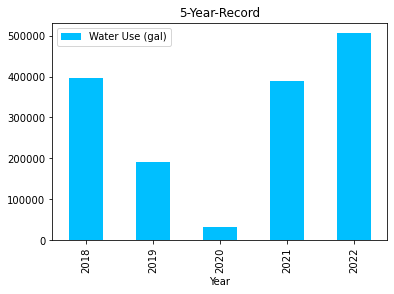

In [9]:
year_df.plot(kind = 'bar', x = 'Year', y = 'Water Use (gal)', color = 'deepskyblue')
plt.title('5-Year-Record')
plt.show()

In [10]:
df2022

,Date,Year,Month,Day,Time,Water
40072,2022-01-01,2022,1,Saturday,00:00:00,3.63205
40073,2022-01-01,2022,1,Saturday,00:15:00,5.63877
40074,2022-01-01,2022,1,Saturday,00:30:00,3.63215
40075,2022-01-01,2022,1,Saturday,00:45:00,6.19221
40076,2022-01-01,2022,1,Saturday,01:00:00,0.27672
...,...,...,...,...,...,...
25069,2022-12-31,2022,12,Saturday,22:45:00,0.86475
25070,2022-12-31,2022,12,Saturday,23:00:00,3.35533
25071,2022-12-31,2022,12,Saturday,23:15:00,2.83638
25072,2022-12-31,2022,12,Saturday,23:30:00,0.89934


In [12]:
months = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
monthly_usage_2022 = []

for month in months:
    buffer = df2022[df2022['Month'] == month]
    total = buffer['Water'].sum(axis = 0)
    monthly_usage_2022.append(total)
    
# monthly_usage
record_of_2022 = {
    'Month' : months,
    'Water Use (gal)' : monthly_usage_2022
}

df_2022_rec = pd.DataFrame(record_of_2022, columns = ['Month', 'Water Use (gal)'])
df_2022_rec

,Month,Water Use (gal)
0,1,44958.98543
1,2,50846.98439
2,3,63220.42987
3,4,50584.17156
4,5,60384.46523
5,6,8917.16964
6,7,2503.42018
7,8,13819.77730
8,9,59754.67702
9,10,54018.68021


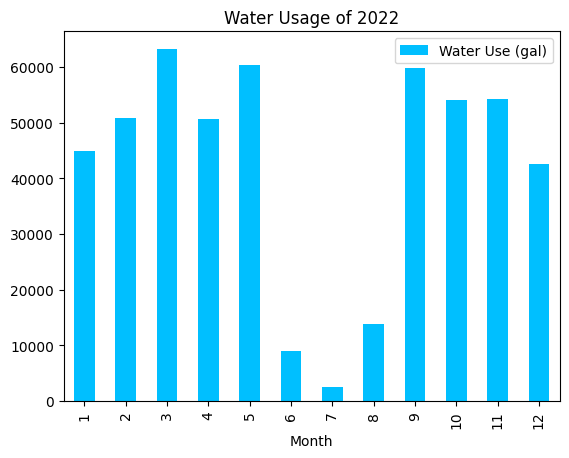

In [ ]:
df_2022_rec.plot(kind = 'bar', x = 'Month', y = 'Water Use (gal)', color = 'deepskyblue')
plt.title('Water Usage of 2022')
plt.show()

In [13]:
df2021 = new_df[new_df['Year'] == 2021]
monthly_usage_2021 = []

for month in months:
    buffer = df2021[df2021['Month'] == month]
    total = buffer['Water'].sum(axis = 0)
    monthly_usage_2021.append(total)
    
# monthly_usage
record_of_2021 = {
    'Month' : months,
    'Water Use (gal)' : monthly_usage_2021
}

df_2021_rec = pd.DataFrame(record_of_2021, columns = ['Month', 'Water Use (gal)'])
df_2021_rec

,Month,Water Use (gal)
0,1,17619.68137
1,2,39708.01290
2,3,44386.10663
3,4,43010.03623
4,5,20530.00501
5,6,1694.01337
6,7,2642.14267
7,8,29102.07780
8,9,24505.47861
9,10,61465.04869


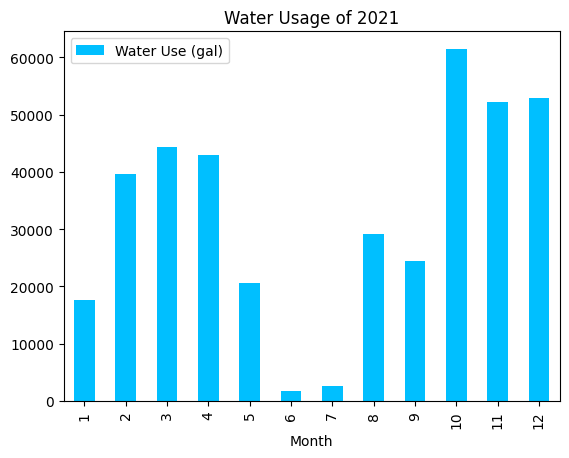

In [ ]:
df_2021_rec.plot(kind = 'bar', x = 'Month', y = 'Water Use (gal)', color = 'deepskyblue')
plt.title('Water Usage of 2021')
plt.show()

In [ ]:
from datetime import datetime
from datetime import timedelta
def get_3best_time(month=datetime.now().month, day=datetime.now().day, earliest='08:00', latest='23:45', trained_model=rgs):
    earliest = datetime.strptime(earliest, '%H:%M')
    latest = datetime.strptime(latest, '%H:%M')

    time_array = []
    while True:
        time_array.append(earliest.time())
        if earliest == latest:
            break
        earliest += timedelta(minutes=15)
        
    cur_X = pd.DataFrame({'Month': month, 'Day': datetime(datetime.now().year, month, day).strftime('%A'), 'Time': time_array})
    cur_X_transformed = transformer.transform(cur_X)
    y = trained_model.predict(cur_X_transformed)
    cur_X['Water'] = trained_model.predict(cur_X_transformed)
    top_3 = cur_X.iloc[cur_X['Water'].argsort()[:3]]
    return top_3[['Time', 'Water']].reset_index(drop=True)
get_3best_time()    

,Time,Water
0,18:30:00,4.259251
1,18:45:00,4.859377
2,19:45:00,5.773612


In [ ]:
month = 1
day = 24
get_3best_time(1, 24, '19:00', '22:00') 

,Time,Water
0,19:45:00,5.773612
1,19:00:00,6.925329
2,19:30:00,7.329451


In [14]:
agg_df = df.groupby(['Day', 'Time']).agg({'Water': 'mean'})

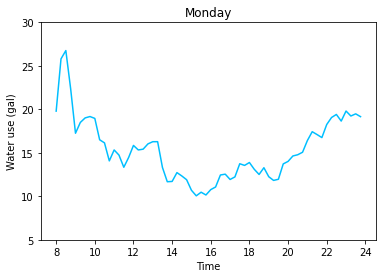

In [18]:
mon = agg_df.loc['Monday']

plt.figure()
plt.plot(np.arange(8, 24, 0.25), mon['Water'], color='deepskyblue')
plt.ylim(5, 30)
plt.title("Monday")
plt.xlabel('Time')
plt.ylabel('Water use (gal)')
plt.show()

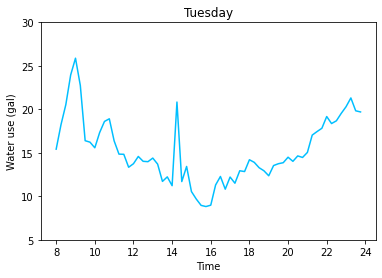

In [20]:
tue = agg_df.loc['Tuesday']

plt.figure()
plt.plot(np.arange(8, 24, 0.25), tue['Water'], color='deepskyblue')
plt.ylim(5, 30)
plt.title("Tuesday")
plt.xlabel('Time')
plt.ylabel('Water use (gal)')
plt.show()

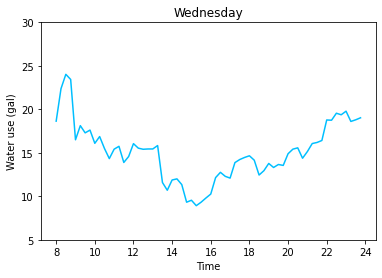

In [21]:
wed = agg_df.loc['Wednesday']

plt.figure()
plt.plot(np.arange(8, 24, 0.25), wed['Water'], color='deepskyblue')
plt.ylim(5, 30)
plt.title("Wednesday")
plt.xlabel('Time')
plt.ylabel('Water use (gal)')
plt.show()

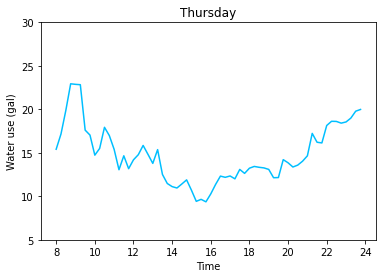

In [22]:
thu = agg_df.loc['Thursday']

plt.figure()
plt.plot(np.arange(8, 24, 0.25), thu['Water'], color='deepskyblue')
plt.ylim(5, 30)
plt.title("Thursday")
plt.xlabel('Time')
plt.ylabel('Water use (gal)')
plt.show()

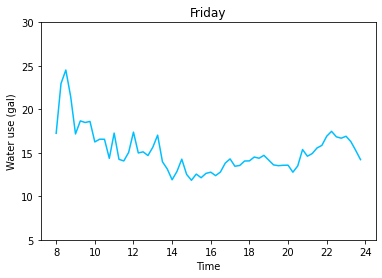

In [23]:
fri = agg_df.loc['Friday']

plt.figure()
plt.plot(np.arange(8, 24, 0.25), fri['Water'], color='deepskyblue')
plt.ylim(5, 30)
plt.title("Friday")
plt.xlabel('Time')
plt.ylabel('Water use (gal)')
plt.show()

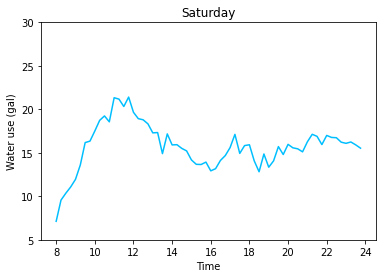

In [24]:
sat = agg_df.loc['Saturday']

plt.figure()
plt.plot(np.arange(8, 24, 0.25), sat['Water'], color='deepskyblue')
plt.ylim(5, 30)
plt.title("Saturday")
plt.xlabel('Time')
plt.ylabel('Water use (gal)')
plt.show()

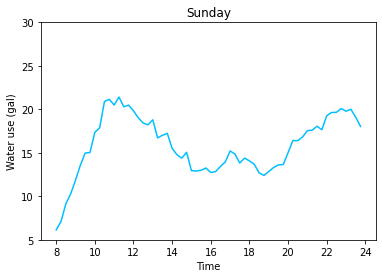

In [25]:
sun = agg_df.loc['Sunday']

plt.figure()
plt.plot(np.arange(8, 24, 0.25), sun['Water'], color='deepskyblue')
plt.ylim(5, 30)
plt.title("Sunday")
plt.xlabel('Time')
plt.ylabel('Water use (gal)')
plt.show()

### III. Machine Learning Model

We decided to use Neural Network as our model. As mentioned above, **X** will consist of **Month, Day, and Time** columns and **y** will be the **Water** column.

We splitted our dataset into 2 new sets: the **training set** and the **test set**.

In [33]:
df['Time'] = pd.to_datetime(df['Time']).dt.time

from datetime import time
df = df[df['Time'] >= time(8)]      #Exclude timestamp before 8 am

df = df.reset_index(drop=True)


#Test set: Year 2022
start = df[df['Date'] == '2022-01-01'].iloc[0].name
end = df[df['Date'] == '2022-12-31'].iloc[-1].name
df_test = df.iloc[start: end]
df_train = df.iloc[: start]

df_train = df_train[['Month', 'Day', 'Time', 'Water']]

df_train      #Final dataset

from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

X = df_train.drop('Water', axis=1)
y = df_train['Water']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
transformer = OneHotEncoder()
X_train_transformed = transformer.fit_transform(X_train)
X_test_transformed = transformer.transform(X_test)

Our Neural Network consists of 10 neurons and 1 layer. Time to run the model:

In [35]:
rgs = MLPRegressor(hidden_layer_sizes=(10,))
rgs.fit(X_train_transformed, y_train)
y_pred = rgs.predict(X_test_transformed)

c:\Users\admin\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Below is our predicted set:

In [ ]:
pd.Series(y_pred)

0         5.594178
1        18.308986
2        17.590155
3         7.618063
4         2.910586
           ...    
14512    16.532441
14513    21.947257
14514    12.434825
14515     4.344658
14516     4.185045
Length: 14517, dtype: float64

And below is our test set to compare with our predicted set:

Using r2_score to examine our accuracy:

In [ ]:
from sklearn.metrics import r2_score
r2_score(y_test, y_pred)

0.2750049936448642

In [ ]:
df_test = df_test.reset_index(drop=True)
df_test.columns = ['Date', 'Year',	'Month',	'Day',	'Time',	'Water']
df_test

,Date,Year,Month,Day,Time,Water
0,2022-01-01,2022,1,Saturday,08:00:00,1.59134
1,2022-01-01,2022,1,Saturday,08:15:00,0.24213
2,2022-01-01,2022,1,Saturday,08:30:00,0.65721
3,2022-01-01,2022,1,Saturday,08:45:00,0.17295
4,2022-01-01,2022,1,Saturday,09:00:00,0.20754
...,...,...,...,...,...,...
23316,2022-12-31,2022,12,Saturday,22:30:00,1.34901
23317,2022-12-31,2022,12,Saturday,22:45:00,0.86475
23318,2022-12-31,2022,12,Saturday,23:00:00,3.35533
23319,2022-12-31,2022,12,Saturday,23:15:00,2.83638


In [51]:
best_time_true = df_test.groupby('Date').apply(lambda d: d.iloc[d['Water'].argsort()[:10]]['Time']) 
best_time_true

Date             
2022-01-01  58099    15:45:00
            58071    08:45:00
            58088    13:00:00
            58072    09:00:00
            58091    13:45:00
                       ...   
2022-12-31  81382    22:00:00
            81388    23:30:00
            81372    19:30:00
            81377    20:45:00
            81379    21:15:00
Name: Time, Length: 3650, dtype: object

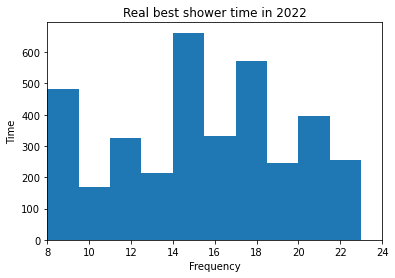

In [52]:

plt.figure()
best_time_true_hour = best_time_true.apply(lambda x: x.hour)
plt.hist(best_time_true_hour)
plt.xlabel('Frequency')
plt.ylabel('Time')
plt.title('Real best shower time in 2022')
plt.xlim(8, 24)
plt.show()

In [55]:
X_test1 = df_test[['Month', 'Day', 'Time']]
X_test1_tranformed = transformer.transform(X_test1)
X_test1['Water'] = rgs.predict(X_test1_tranformed)
X_test1['Date'] = df_test['Date']
best_time_pred = X_test1.groupby('Date').apply(lambda d: d.iloc[d['Water'].argsort()[:10]]['Time']) 
best_time_pred

C:\Users\admin\AppData\Local\Temp\ipykernel_12264\1765104477.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test1['Water'] = rgs.predict(X_test1_tranformed)
C:\Users\admin\AppData\Local\Temp\ipykernel_12264\1765104477.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test1['Date'] = df_test['Date']


Date             
2022-01-01  58068    08:00:00
            58069    08:15:00
            58070    08:30:00
            58110    18:30:00
            58111    18:45:00
                       ...   
2022-12-31  81369    18:45:00
            81368    18:30:00
            81359    16:15:00
            81367    18:15:00
            81355    15:15:00
Name: Time, Length: 3650, dtype: object

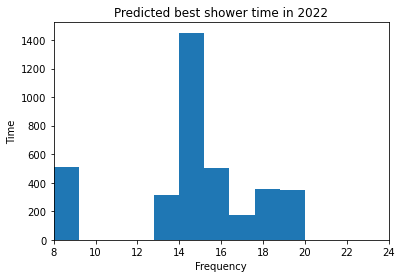

In [56]:
plt.figure()
best_time_pred_hour = best_time_pred.apply(lambda x: x.hour)
plt.hist(best_time_pred_hour)
plt.xlabel('Frequency')
plt.ylabel('Time')
plt.title('Predicted best shower time in 2022')
plt.xlim(8, 24)
plt.show()